In [ ]:
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dropout, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import numpy as np
import pickle

In [ ]:
# Mount with my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_data_path = "/content/drive/MyDrive/Tài liệu/PBL7/Data/Weather_Transformed.csv"
data_train_path = "/content/drive/MyDrive/Tài liệu/PBL7/Data/weather_train.csv"
data_test_path = "/content/drive/MyDrive/Tài liệu/PBL7/Data/weather_test.csv"
pickle_path = "/content/drive/MyDrive/Tài liệu/PBL7/Data/scaler.pkl"

In [ ]:
with open(pickle_path, 'rb') as f:
    scaler = pickle.load(f)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
df = pd.read_csv(all_data_path)
df.head()

,Date,Time,Weather,Temp,Rain,Cloud,Pressure,Wind
0,2009-01-01,00:00,patchy rain possible,15,0.000000,100,1021,5.012414
1,2009-01-01,03:00,moderate rain at times,16,0.000000,100,1021,5.449856
2,2009-01-01,06:00,heavy rain at times,15,0.086566,100,1021,5.163153
3,2009-01-01,09:00,moderate rain at times,16,0.000000,100,1023,5.449856
4,2009-01-01,12:00,moderate rain at times,15,0.000000,100,1021,5.012414


In [ ]:
df_train = pd.read_csv(data_train_path)
df_train

,Date,Time,Weather,Temp,Rain,Cloud,Pressure,Wind
0,2009-01-01,00:00,patchy rain possible,-2.019447,-0.292858,1.423837,1.718056,1.279488
1,2009-01-01,03:00,moderate rain at times,-1.814438,-0.292858,1.423837,1.718056,1.677434
2,2009-01-01,06:00,heavy rain at times,-2.019447,3.414031,1.423837,1.718056,1.416617
3,2009-01-01,09:00,moderate rain at times,-1.814438,-0.292858,1.423837,2.043605,1.677434
4,2009-01-01,12:00,moderate rain at times,-2.019447,-0.292858,1.423837,1.718056,1.279488
...,...,...,...,...,...,...,...,...
37979,2021-12-31,09:00,moderate rain at times,-1.404419,-0.292858,1.423837,2.043605,0.330110
37980,2021-12-31,12:00,heavy rain at times,-1.404419,3.414031,1.423837,1.880831,0.989629
37981,2021-12-31,15:00,heavy rain at times,-1.404419,3.414031,1.423837,1.555282,0.835818
37982,2021-12-31,18:00,heavy rain at times,-1.404419,3.414031,1.127571,1.718056,0.675204


In [ ]:
df_valid = df_train[df_train['Date'] >= '2019-01-01']
df_train = df_train[df_train['Date'] < '2019-01-01']

In [ ]:
df_test = pd.read_csv(data_test_path)
df_test

,Date,Time,Weather,Temp,Rain,Cloud,Pressure,Wind
0,2022-01-01,00:00,heavy rain at times,-1.609428,3.414031,0.949812,1.880831,0.143416
1,2022-01-01,03:00,patchy rain possible,-1.404419,-0.292858,1.423837,1.718056,0.143416
2,2022-01-01,06:00,patchy rain possible,-1.404419,-0.292858,1.423837,1.718056,0.143416
3,2022-01-01,09:00,patchy rain possible,-1.199410,-0.292858,1.423837,2.043605,-0.054636
4,2022-01-01,12:00,patchy rain possible,-1.199410,-0.292858,1.423837,1.718056,0.989629
...,...,...,...,...,...,...,...,...
8763,2024-12-31,09:00,light rain shower,-1.199410,-0.292858,1.127571,1.880831,0.989629
8764,2024-12-31,12:00,light rain shower,-1.199410,-0.292858,1.423837,1.555282,1.137325
8765,2024-12-31,15:00,light rain shower,-1.199410,-0.292858,1.423837,1.066959,0.835818
8766,2024-12-31,18:00,patchy rain possible,-1.404419,-0.292858,1.157198,1.229734,0.143416


In [ ]:
def format_date_time(df):
  if 'Date' in df.columns and 'Time' in df.columns:
    df.loc[:, "Formatted Date"] = df['Date'].astype(str) + ' ' + df['Time'].astype(str)
    df = df.drop(columns=["Date", "Time"])
    df = df.set_index(pd.DatetimeIndex(df['Formatted Date']))
    df = df.drop('Formatted Date', axis=1)
    df = df.drop('Weather', axis=1)
    df.index.name = 'date'
    return df
  else:
    print("DataFrame không có cột 'Date' hoặc 'Time'.")
    return df

In [ ]:
df_train = format_date_time(df_train)
df_valid = format_date_time(df_valid)
df_test = format_date_time(df_test)

<ipython-input-10-faaa70da7b81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Formatted Date"] = df['Date'].astype(str) + ' ' + df['Time'].astype(str)
<ipython-input-10-faaa70da7b81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Formatted Date"] = df['Date'].astype(str) + ' ' + df['Time'].astype(str)


In [ ]:
df_test

,Temp,Rain,Cloud,Pressure,Wind
date,,,,,
2022-01-01 00:00:00,-1.609428,3.414031,0.949812,1.880831,0.143416
2022-01-01 03:00:00,-1.404419,-0.292858,1.423837,1.718056,0.143416
2022-01-01 06:00:00,-1.404419,-0.292858,1.423837,1.718056,0.143416
2022-01-01 09:00:00,-1.199410,-0.292858,1.423837,2.043605,-0.054636
2022-01-01 12:00:00,-1.199410,-0.292858,1.423837,1.718056,0.989629
...,...,...,...,...,...
2024-12-31 09:00:00,-1.199410,-0.292858,1.127571,1.880831,0.989629
2024-12-31 12:00:00,-1.199410,-0.292858,1.423837,1.555282,1.137325
2024-12-31 15:00:00,-1.199410,-0.292858,1.423837,1.066959,0.835818


In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
n_hours = 8
n_features = 5
n_predict = 1

In [ ]:
def create_dataset(dataset, n_hours, n_features, n_predict):
    dataX, dataY = [], []

    data = dataset.values
    data = data.astype('float32')

    reframed = series_to_supervised(data, n_hours, n_predict)
    reframed = reframed.values

    dataX = reframed[:, :n_hours*n_features]
    dataY = reframed[:, -n_features]

    dataX = dataX.reshape(dataX.shape[0], n_hours, n_features)

    return dataX, dataY


In [ ]:
X_train, Y_train = create_dataset(df_train, n_hours, n_features, n_predict)
X_val, Y_val = create_dataset(df_valid, n_hours, n_features, n_predict)
X_test, Y_test = create_dataset(df_test, n_hours, n_features, n_predict)

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(29208, 8, 5) (29208,)
(8760, 8, 5) (8760,)
(8760, 8, 5) (8760,)


# **Model**



In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(256,name='FC1'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1,name='out_layer'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                  epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.1557 - mean_squared_error: 0.1557 - val_loss: 0.0416 - val_mean_squared_error: 0.0416
Epoch 2/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 3/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 4/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0311 - val_mean_squared_error: 0.0311
Epoch 5/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 6/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0346 - mean_squared_error: 0.0346 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 7/100
913/913 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - val_lo

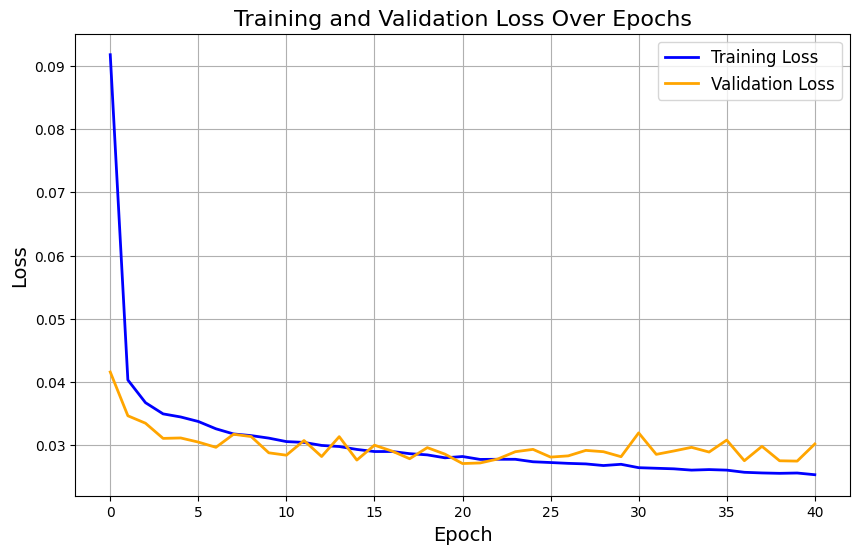

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.grid(True)

plt.legend(fontsize=12)

plt.show()


In [ ]:
model.save("lstm_model.h5")

In [ ]:
# make a prediction
Y_test_predicted = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], n_hours*n_features))

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


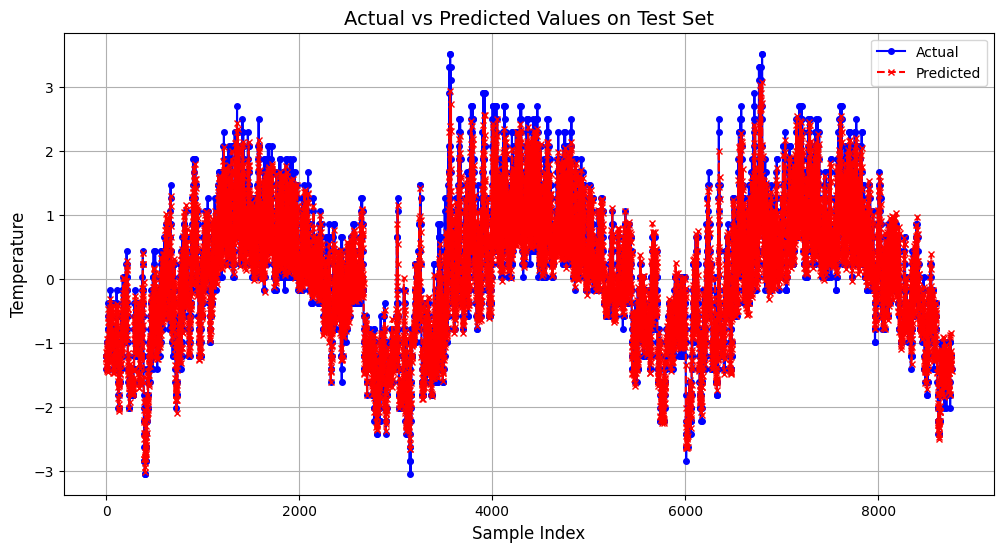

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(Y_test, label="Actual", color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(Y_test_predicted, label="Predicted", color='red', linestyle='--', marker='x', markersize=4)

plt.title('Actual vs Predicted Values on Test Set', fontsize=14)

plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Temperature', fontsize=12)

plt.grid(True)
plt.legend()

plt.show()

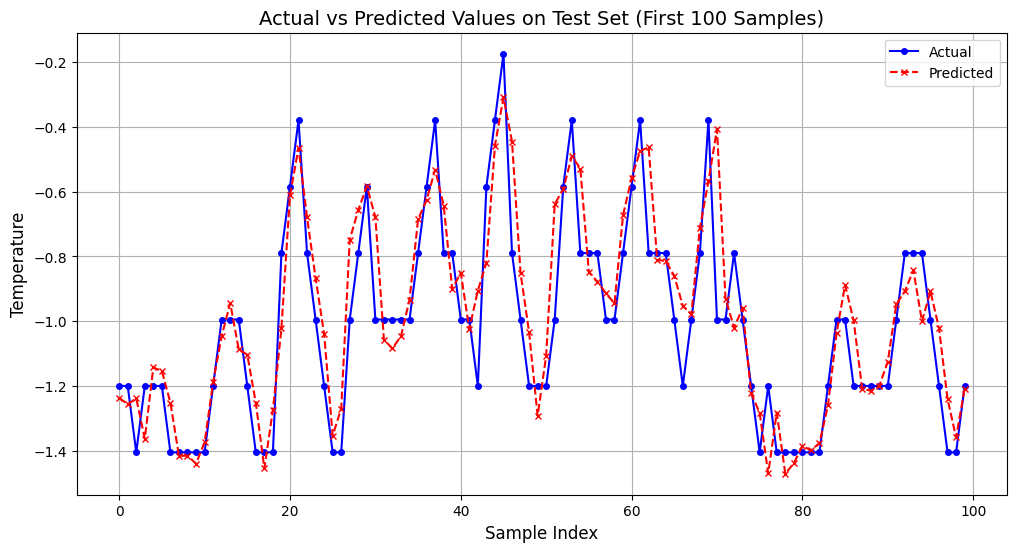

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(Y_test[:100], label="Actual", color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(Y_test_predicted[:100], label="Predicted", color='red', linestyle='--', marker='x', markersize=4)

plt.title('Actual vs Predicted Values on Test Set (First 100 Samples)', fontsize=14)

plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Temperature', fontsize=12)

plt.grid(True)
plt.legend()

plt.show()

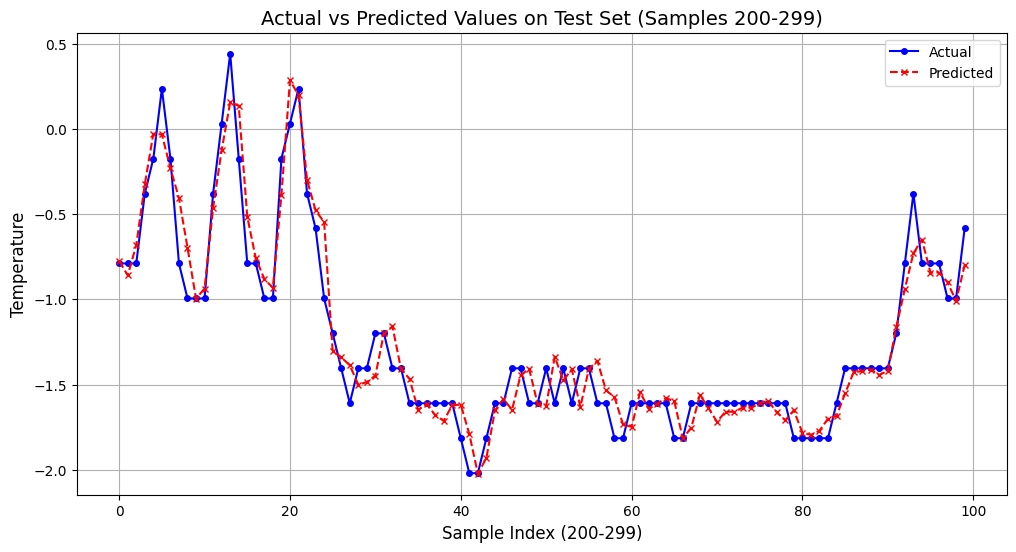

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(Y_test[200:300], label="Actual", color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(Y_test_predicted[200:300], label="Predicted", color='red', linestyle='--', marker='x', markersize=4)

plt.title('Actual vs Predicted Values on Test Set (Samples 200-299)', fontsize=14)

plt.xlabel('Sample Index (200-299)', fontsize=12)
plt.ylabel('Temperature', fontsize=12)

plt.grid(True)
plt.legend()
plt.show()


In [ ]:
inv_test_Y_predicted = np.concatenate((Y_test_predicted, X_test[:, -4:]), axis=1)
inv_test_Y_predicted = scaler.inverse_transform(inv_test_Y_predicted)
inv_test_Y_predicted = inv_test_Y_predicted[:,0]
print(inv_test_Y_predicted)

[18.697071 18.60038  18.688843 ... 18.514917 18.160345 17.702784]


In [ ]:
inv_test_Y = np.concatenate((Y_test.reshape(-1, 1), X_test[:, -4:]), axis=1)
inv_test_Y = scaler.inverse_transform(inv_test_Y)
inv_test_Y = inv_test_Y[:,0]
print(inv_test_Y)

[18.877333 18.877333 17.87131  ... 18.877333 17.87131  17.87131 ]


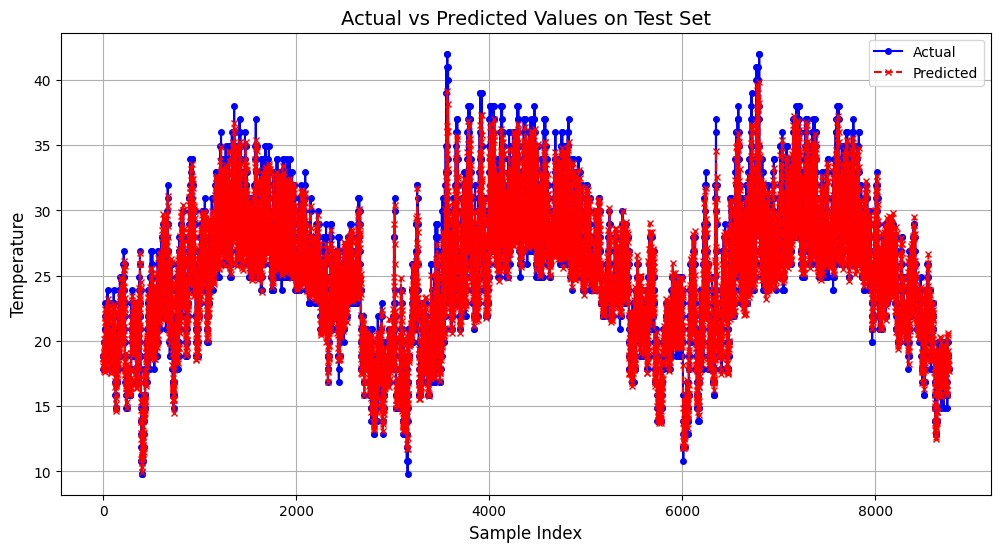

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(inv_test_Y, label="Actual", color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(inv_test_Y_predicted, label="Predicted", color='red', linestyle='--', marker='x', markersize=4)

plt.title('Actual vs Predicted Values on Test Set', fontsize=14)

plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Temperature', fontsize=12)

plt.grid(True)
plt.legend()

plt.show()

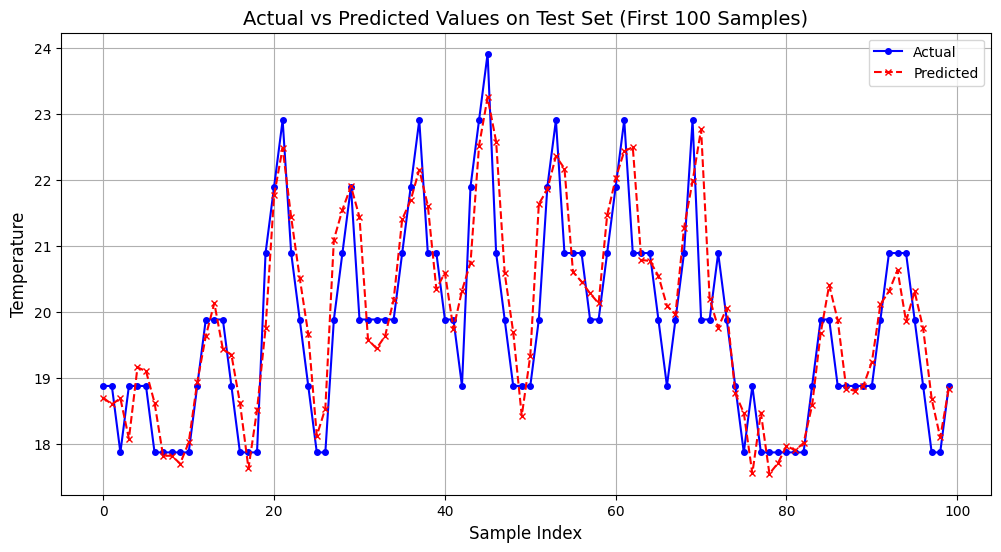

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(inv_test_Y[:100], label="Actual", color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(inv_test_Y_predicted[:100], label="Predicted", color='red', linestyle='--', marker='x', markersize=4)

plt.title('Actual vs Predicted Values on Test Set (First 100 Samples)', fontsize=14)

plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Temperature', fontsize=12)

plt.grid(True)
plt.legend()

plt.show()

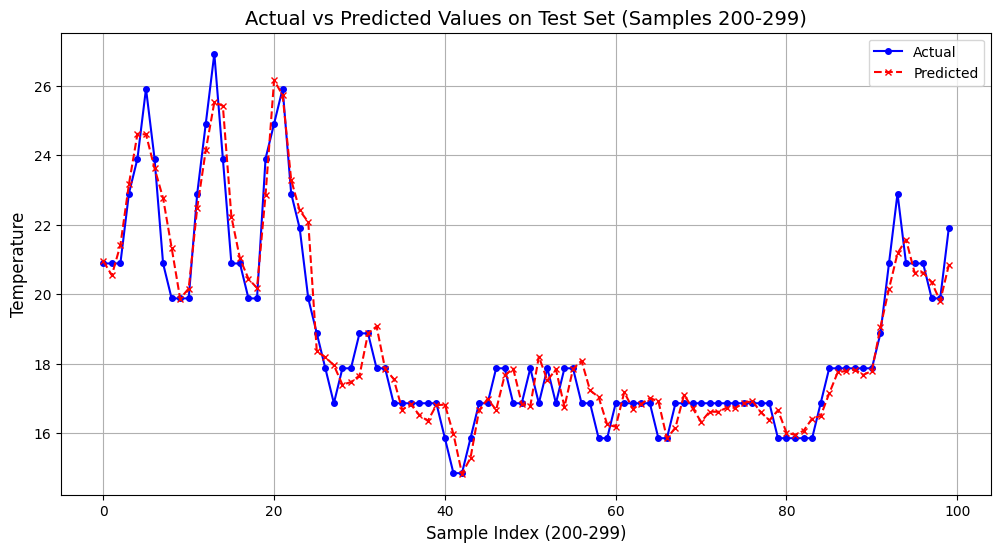

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(inv_test_Y[200:300], label="Actual", color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(inv_test_Y_predicted[200:300], label="Predicted", color='red', linestyle='--', marker='x', markersize=4)

plt.title('Actual vs Predicted Values on Test Set (Samples 200-299)', fontsize=14)

plt.xlabel('Sample Index (200-299)', fontsize=12)
plt.ylabel('Temperature', fontsize=12)

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(inv_test_Y, inv_test_Y_predicted)
print('Test MSE: %.3f' % mse)

Test MSE: 0.974
